# Data 11800 - Autumn 2022
# Homework 7: A/B testing and fuzzy matching (50 points)

**Reading**: Textbook chapter [12](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.  

Homework 7 is due Thursday, Dec 1 at 9:00am. Late work will not be accepted.  

In [1]:
# Don't change this cell; just run it. 

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Possum metrology (25 points) 

The data for this exercise were collected in Eastern Australia and represent various measurements of possum dimensions of 102 animals caught at 7 locations in Victoria, New South Wales, and Queensland in October and November of 1993. Source of data: 

Lindenmayer, D. B., Viggers, K. L., Cunningham, R. B., and Donnelly, C. F. 1995. Morphological variation among columns of the mountain brushtail possum, Trichosurus caninus Ogilby (Phalangeridae: Marsupiala). Australian Journal of Zoology 43: 449-458. 

Variables in the dataset:

- site: one of seven locations where possums were trapped. The sites were, in order, Cambarville, Bellbird, Whian Whian, Byrangery, Conondale, Allyn River and Bulburin
- pop:  a factor which classifies the sites as Vic (for Victoria) and other (New South Wales or Queensland)
- sex: a factor with levels f female, m male
- age (inferred from inspecting the teeth of the unlucky marsupials under sedation)
- head_l:  head length
- skull_w:  skull width
- total_l: total length
- tail_l: tail length

We believe that the units for `age` is  years, for `head_l`, `skull_w` and `tail_l` are mm; possums are about 30 cm long so  `total_l` and `tail_l` are in cm.  


In [2]:
# read the data
p_df = pd.read_csv("data/possum.csv")
p_df.head()

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0


In [3]:
# some data summaries
p_df.describe()

,site,age,head_l,skull_w,total_l,tail_l
count,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000
mean,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615
std,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518
min,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000
25%,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000
50%,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000
75%,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000
max,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000


**Question 1** Produce an adequately-labeled scatterplot of total length (y axis) vs. age (x axis). Explain why the plot has prominent vertical lines.

Text(0.5, 1.0, 'Relationship between Possium Length and Age')

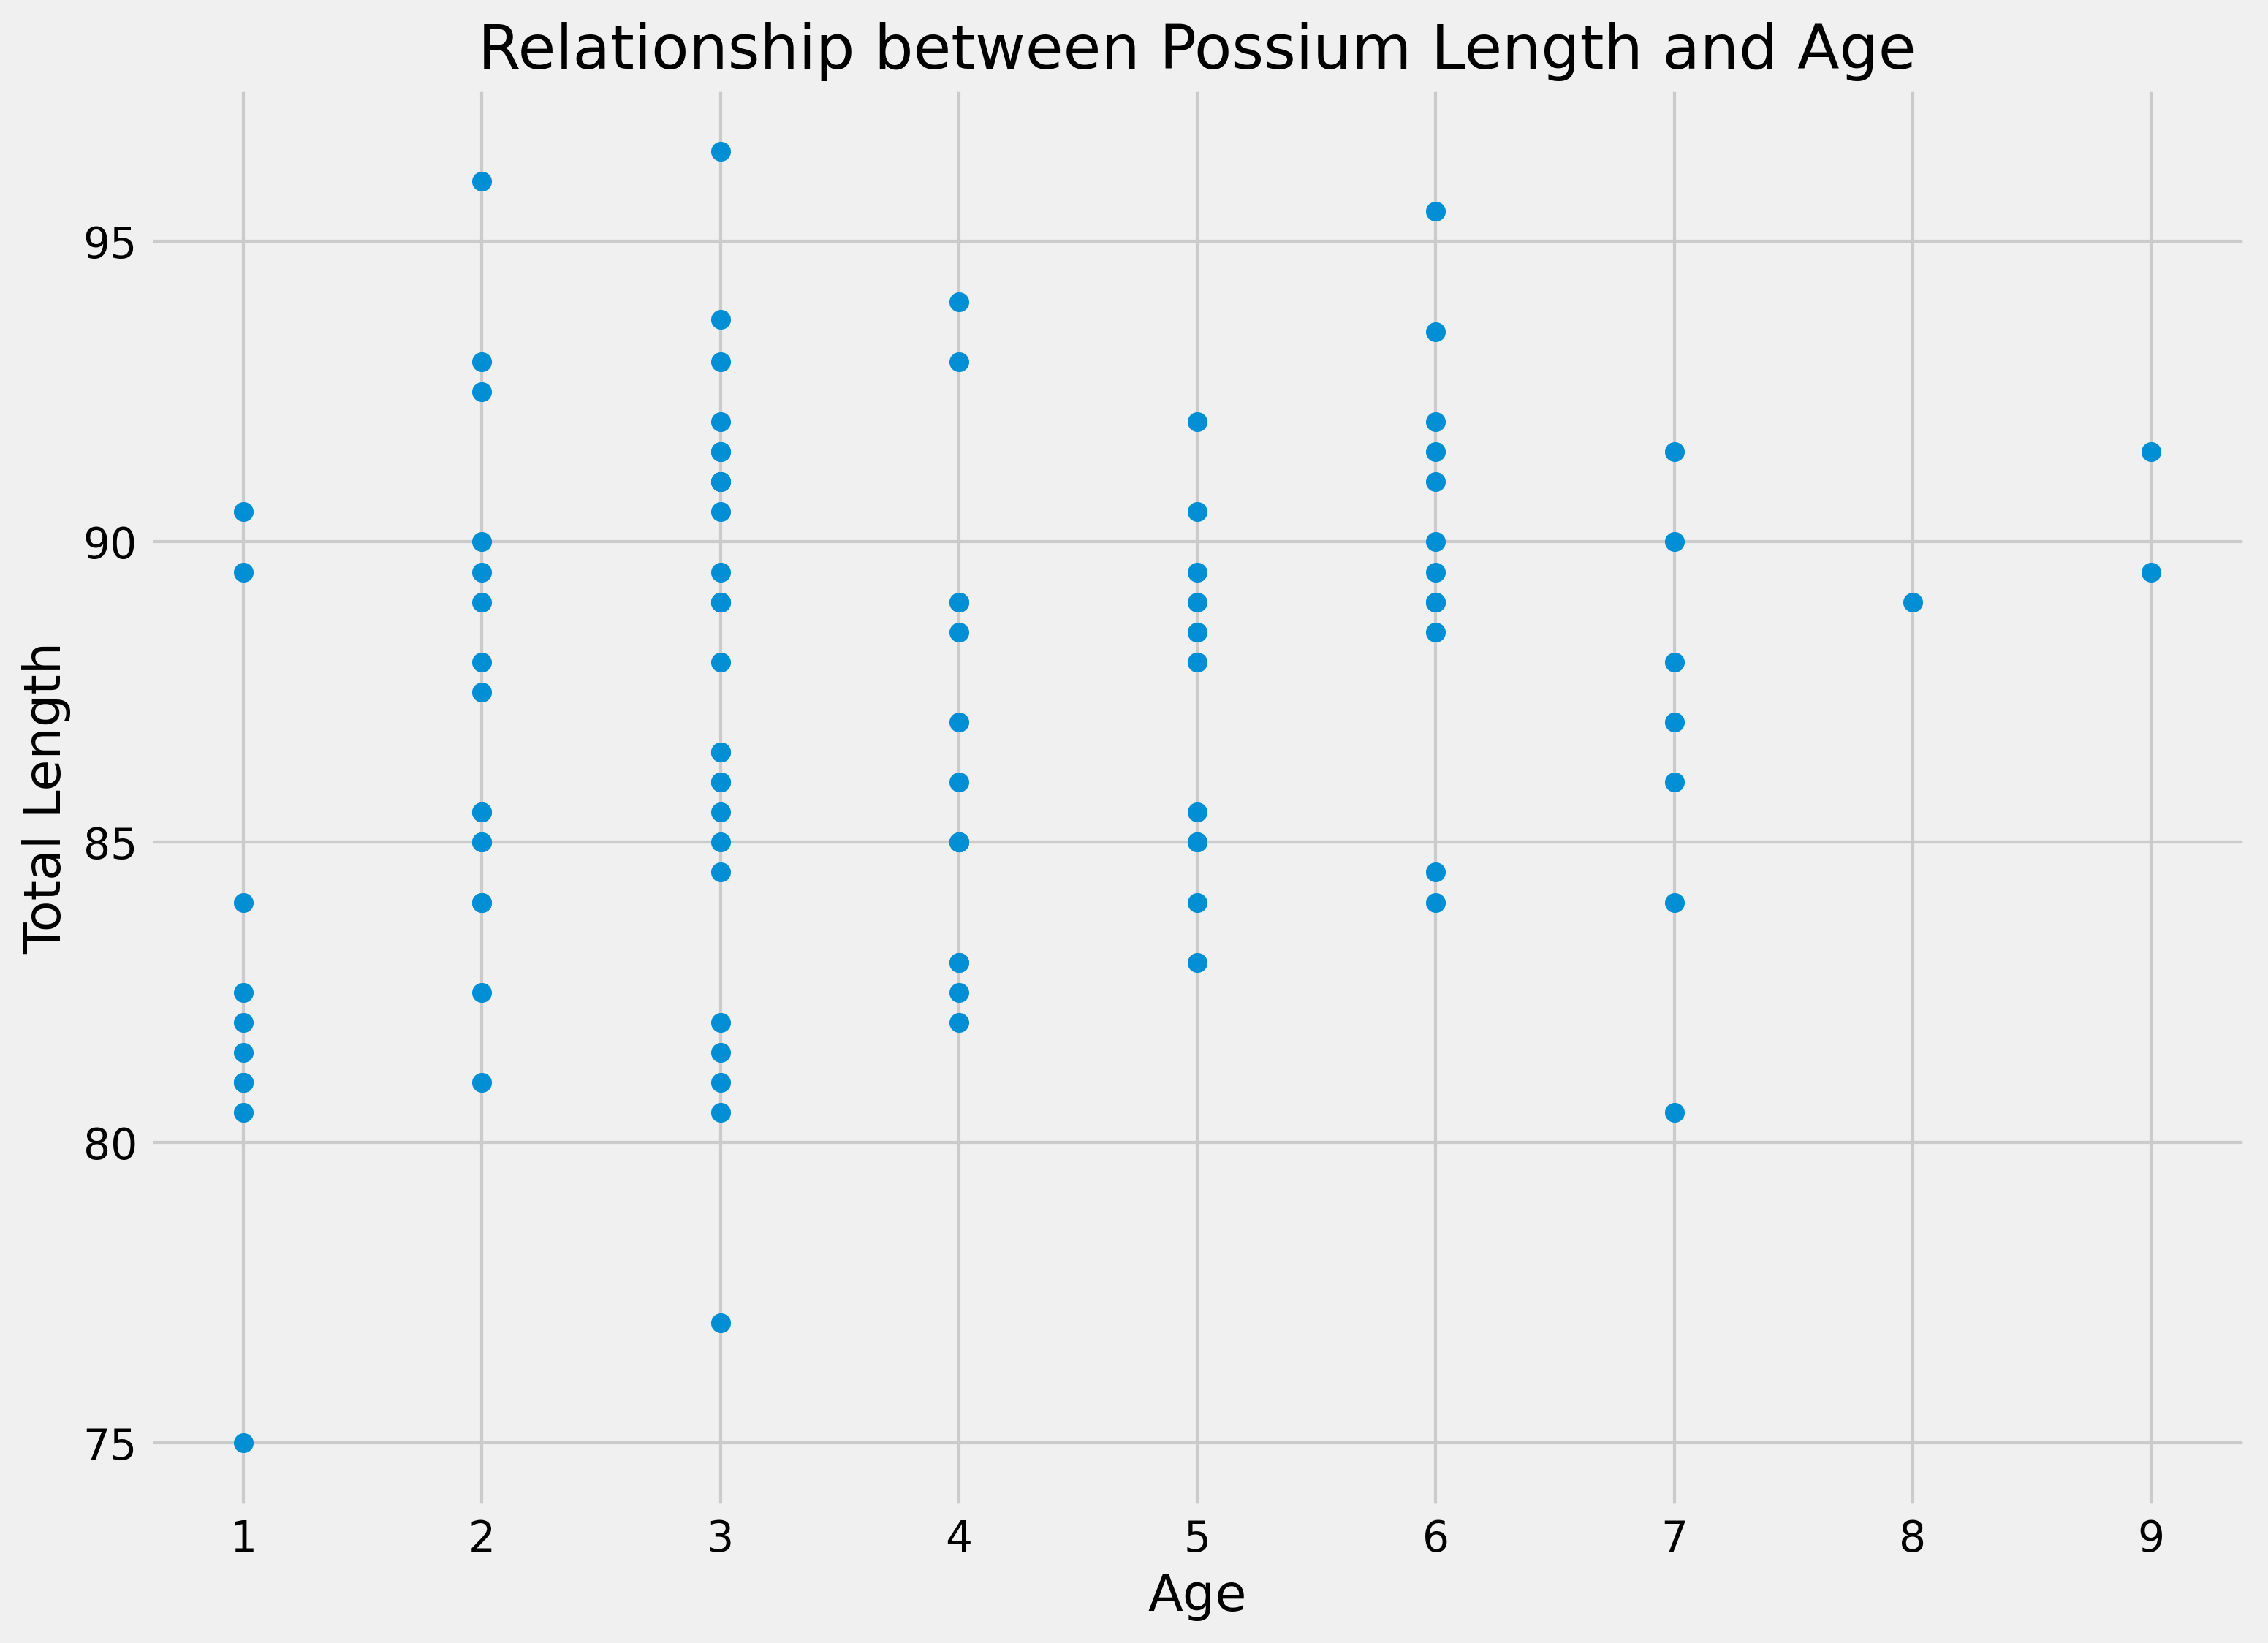

In [4]:
# code here
plt.figure(figsize=[11,8],dpi=300)
plt.scatter(p_df['age'],p_df['total_l'])
plt.xlabel('Age')
plt.ylabel('Total Length')
plt.title('Relationship between Possium Length and Age')

*Answer:* For a given age, possums can be a wide range of lengths. Additionally, age is measured in discrete values (here by year) meaning a possum that just turned 3 vs almost 4 years old (e.g. 3 years and 11 months old) are both 3 years here.


**Question 2.** Test for sexual dimorphism in the skull width measurement in the sampled possums.  (Do the male and female possums have different skull widths?)  This should be done using the permutation method. Display the (permutation generated) null distribution of your test statistic and the observed value of the test statistic. Report the p-value for this null hypothesis that the two sexes have the same skull width distribution.

-0.5034311856652636
p-value: 0.2084


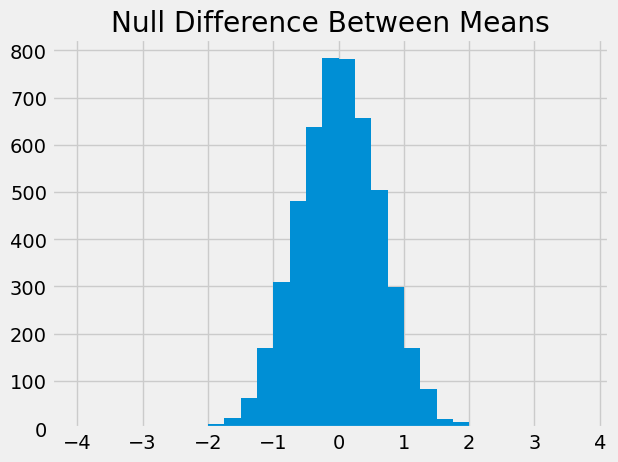

In [5]:
# permutation generated df
widths = p_df[['skull_w']]
group_labels = p_df['sex'].values
differences = np.array([])

for _ in np.arange(5000):
    shuffled_widths = widths.sample(len(widths),replace = False)['skull_w'].values
    shuffled_df=pd.DataFrame({"Shuffled Widths":shuffled_widths,"Label":group_labels})
    smeans_df=shuffled_df.groupby('Label').mean()
    new_diff=smeans_df.iloc[0]-smeans_df.iloc[1] 
    differences = np.append(differences, new_diff)

# plot of permutation generated null distribution
plt.hist(differences,bins=np.arange(-4,4,0.25))
plt.title("Null Difference Between Means");

# observed value of test stat
means_df = p_df.groupby('sex')['skull_w'].mean()
observed_difference = means_df.iloc[0] - means_df.iloc[1]
print(observed_difference)

# p-value
print('p-value:',np.count_nonzero(observed_difference > differences) / len(differences))

**Question 3.** Simlarly to Question 2, test the hypothesis of equality in distributions for the tail lengths of male possums sampled in Victoria (sites 1 and 2) and the tail lengths of male possums sampled outside of Victoria.

This should be done using the permutation method. Display the (permutation generated) null distribution of your test statistics and the observed value of the test statistic. Report the p-value for this null hypothesis that the two groups have the same tail length distribution.

In [6]:
p_df.columns

Index(['site', 'pop', 'sex', 'age', 'head_l', 'skull_w', 'total_l', 'tail_l'], dtype='object')

In [7]:
p_df['sex'].unique()

array(['m', 'f'], dtype=object)

In [8]:
for c in ['site','pop']:
    print(p_df[c].unique())

[1 2 3 4 5 6 7]
['Vic' 'other']


In [9]:
q3_df = p_df[p_df['sex'] == 'm'].copy()
def q3_classes(site):
    if site == 1 or site == 2:
        return 'Vic'
    else:
        return 'outside Vic'
q3_df['labs'] = q3_df['site'].apply(q3_classes)

-2.2564102564102555
p-value: 0.0


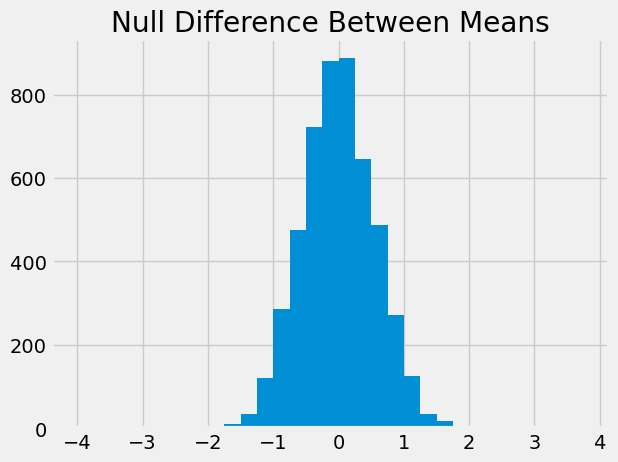

In [10]:
# permutation generated df
lengths = q3_df[['tail_l']]
group_labels = q3_df['labs'].values
differences = np.array([])

for _ in np.arange(5000):
    shuffled_lengths = lengths.sample(len(lengths),replace = False)['tail_l'].values
    shuffled_df=pd.DataFrame({"Shuffled Lengths":shuffled_lengths,"Label":group_labels})
    smeans_df=shuffled_df.groupby('Label').mean()
    new_diff=smeans_df.iloc[0]-smeans_df.iloc[1] 
    differences = np.append(differences, new_diff)

# plot of permutation generated null distribution
plt.hist(differences,bins=np.arange(-4,4,0.25))
plt.title("Null Difference Between Means");

# observed value of test stat
means_df = q3_df.groupby('labs')['tail_l'].mean()
observed_difference = means_df.iloc[0] - means_df.iloc[1]
print(observed_difference)

# p-value
print('p-value:',np.count_nonzero(observed_difference > differences) / len(differences))

**Question 4.** Write code that constructs a 2x2 table that shows the counts of sex (female and male) in the two sites (Victoria and other).

In [12]:
q4_table = pd.pivot_table(p_df, index= 'pop', values=['total_l'], columns= ['sex'],aggfunc='count')
q4_table['total_l']

sex,f,m
pop,,
Vic,24,22
other,19,39


**Question 5.** Investigate the hypothesis that the porportion of males to females is equal in the Victoria / non-Victoria populations trapped (perform a hypothesis test on the table you constructed in Question 4 using the permutation method). State clearly the null and alternative hypothesis. After you perform the test and report the p-value, briefly talk about the assumptions in your test.

-1.135964912280702
p-value: 0.0138


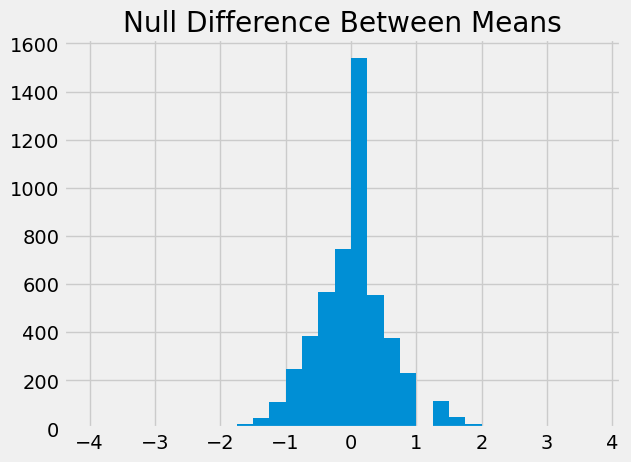

In [16]:
# permutation generated df
sexes = p_df[['sex']]
group_labels = p_df['pop'].values
differences = np.array([])

for _ in np.arange(5000):
    shuffled_sexes = sexes.sample(len(sexes),replace = False)['sex'].values
    shuffled_df=pd.DataFrame({"Shuffled Sexes":shuffled_sexes,"Label":group_labels,"counts":np.zeros(len(sexes))})
    temp = pd.pivot_table(shuffled_df, index='Label', values=['counts'], columns=['Shuffled Sexes'], aggfunc='count')
    vic_prop = temp.iloc[0,1] / temp.iloc[0,0]
    other_prop = temp.iloc[1,1] / temp.iloc[1,0]
    new_diff=vic_prop-other_prop
    differences = np.append(differences, new_diff)

# plot of permutation generated null distribution
plt.hist(differences,bins=np.arange(-4,4,0.25))
plt.title("Null Difference Between Means");

# observed value of test stat
vic_prop = q4_table.iloc[0,1] / q4_table.iloc[0,0]
other_prop = q4_table.iloc[1,1] / q4_table.iloc[1,0]
observed_difference = vic_prop - other_prop
print(observed_difference)

# p-value
print('p-value:',np.count_nonzero(observed_difference > differences) / len(differences))

*Answer here:* 

$\text{H}_\text{0}$: Proportion of males to females is equal in Victoria/non-Victoria populations trapped

$\text{H}_\text{A}$: Proportion of males to females is not equal in Victoria/non-Victoria populations trapped

**Assumptions?** https://stats.stackexchange.com/questions/129485/what-are-the-assumptions-of-the-permutation-test

## 2. Plagiarism detector (25 points) 

We will use the matching techniques discussed in Lecture 15 to construct **a naive plagiarism detector**. We modified the code from the class notebook in two ways: (i) we generalized it to q-character tokens; and (ii) we use spaces instead of #-signs to pad the ends of the strings.

This code allows you to calculate the Jaccard similarity for bigrams, trigrams etc.

In [17]:
#A Function to break a string into qgrams (q-character tokens)
#we'll pad the string with spaces on the front and end
def qgram(str,q):
    str = ' ' + str + ' '
    return([str[i:i+q] for i in range(len(str)-(q-1))])

#compute the jaccard similarity of two strings using qgrams
#pass in a value for q to do anything other than bi-grams
#call jaccard_simq with verbose set to True to see intermediate values

def jaccard_simq(str1, str2,q=2,verbose=False): 
    set1 = set(qgram(str1,q)) 
    set2 = set(qgram(str2,q))
    common_tokens = set1.intersection(set2)
    all_tokens = set1.union(set2)
    if verbose:
        print('set1 =',set1)
        print('set2 =',set2)
        print('Intersection =',common_tokens)
        print('Union =',all_tokens)
        print('Common Tokens =',len(common_tokens),
              'Total Tokens =',len(all_tokens))
    return float(len(common_tokens) / len(all_tokens))


To familiarize yourself with the function, you should try it on several examples and with different values of q. The `verbose=True` option is useful when you want to understand what the function is doing.

In [18]:
jaccard_simq('the quick brown fox','fox quick brown the',verbose=True)

set1 = {'br', 'qu', 'ck', 'ow', ' q', 'ic', 'wn', 'ro', 'x ', 'ui', 'th', 'k ', 'he', 'fo', 'n ', 'e ', ' t', 'ox', ' b', ' f'}
set2 = {'br', 'qu', 'ck', 'ow', ' q', 'ic', 'wn', 'ro', 'x ', 'ui', 'k ', 'th', 'he', 'fo', 'n ', 'e ', ' t', 'ox', ' b', ' f'}
Intersection = {'br', 'qu', 'ck', 'ow', ' q', 'ic', 'wn', 'ro', 'x ', 'ui', 'k ', 'th', 'he', 'fo', 'n ', ' t', 'ox', ' b', ' f', 'e '}
Union = {'br', 'qu', 'ck', 'ow', ' q', 'ic', 'wn', 'ro', 'x ', 'ui', 'th', 'k ', 'he', 'fo', 'n ', 'e ', ' t', 'ox', ' b', ' f'}
Common Tokens = 20 Total Tokens = 20


1.0

In [19]:
jaccard_simq('the quick brown fox','fox quick brown the')

1.0

In [20]:
jaccard_simq('the quick brown fox','fox quick brown the',4,True)

set1 = {'the ', 'ck b', 'fox ', ' qui', 'wn f', 'ick ', ' the', 'rown', 'n fo', 'e qu', 'own ', 'brow', ' fox', 'he q', 'k br', ' bro', 'quic', 'uick'}
set2 = {'quic', 'n th', 'ox q', 'ck b', 'the ', ' qui', 'rown', ' the', 'x qu', 'own ', 'brow', ' fox', 'ick ', 'k br', ' bro', 'fox ', 'wn t', 'uick'}
Intersection = {'the ', 'ck b', 'fox ', ' qui', 'rown', ' the', 'own ', 'brow', ' fox', 'ick ', 'k br', ' bro', 'quic', 'uick'}
Union = {'n th', 'ck b', 'ox q', 'wn f', 'rown', 'n fo', 'e qu', ' fox', 'he q', ' bro', 'fox ', 'wn t', 'uick', 'the ', ' qui', ' the', 'x qu', 'own ', 'brow', 'ick ', 'k br', 'quic'}
Common Tokens = 14 Total Tokens = 22


0.6363636363636364

In [21]:
jaccard_simq('the quick brown fox','fox quick brown the',10)

0.2

The goal of this exercise is to use this function to investigate possible plagiarism in a homework assignment. A homework question asked students to define PageRank. The instructors were worried that the students will copy the answer from Wikipedia, so they decided to use that as a reference. The relevant part of the Wikipedia entry is saved in the file `original.txt` and the command below reads that file into a string.

In [22]:
open("data/original.txt","r",encoding="utf8").read()

'PageRank is a link analysis algorithm used by the Google Internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set. The algorithm may be applied to any collection of entities with reciprocal quotations and references. The numerical weight that it assigns to any given element E is also called the PageRank of E and denoted by PR(E).\nThe name "PageRank" is a trademark of Google, and the PageRank process has been patented (U.S. Patent 6,285,999 ). However, the patent is assigned to Stanford University and not to Google. Google has exclusive license rights on the patent from Stanford University. The university received 1.8 million shares in Google in exchange for use of the patent; the shares were sold in 2005 for $336 million.\nGoogle describes PageRank:\n“ \tPageRank relies on the uniquely democratic nature of the web by using its vast lin

Files containing the answer of five students (A,B,C,D, and E) are provided. They are read as strings using the code below. 

In [24]:
original=open("data/original.txt","r",encoding="utf8").read()
studentA=open("data/studentA.txt","r",encoding="utf8").read()
studentB=open("data/studentB.txt","r",encoding="utf8").read()
studentC=open("data/studentC.txt","r",encoding="utf8").read()
studentD=open("data/studentD.txt","r",encoding="utf8").read()
studentE=open("data/studentE.txt","r",encoding="utf8").read()


#### Question 1

One decision to make is the choice of q in the Jaccard similarity (whether to use 2-character tokens, 20-character tokens etc.) 

Write one advantage and one disadvantage when using 2-character tokens.

Write one advantage and one disadvantage when using 20-character tokens.

**2-character tokens**:

Advantage- we can see if there are specific words that are used that could be similar to those from the original article

Disadvantage- 2-character is so small that we lose structure of the text i.e. not all words are captured since parts of words may be similar i.e. 2 character sequences but the words are more complex/longer

**20-character tokens**:

Advantage- we can capture the structure of the text and see if chunks of the text are similar e.g. phrases or sentences/ordering of words

Disadvantage- 20-characters is so long that even small variations in word choice or changing order of words would result in the similarity score being low and students being able to evade detection

#### Question 2

Calculate the Jaccard similarities between each of the five student responses and the original Wikipedia article. This should be done for all q between 2 and 20.

Save the results in a dataframe with rows indexed by the values of q, and having a column for each student answer showing the similarity of that student answer and the original for each value of q.   Your dataframe should have 19 populated rows with 5 columns.

In [41]:
# put your code to create and output the dataframe here
sims = np.zeros((19,5))
students = [studentA,studentB,studentC,studentD,studentE]
for i,s in enumerate(students):
    stu_sim = np.array([])
    for q in np.arange(2,21):
        temp = jaccard_simq(original,s,q)
        stu_sim = np.append(stu_sim,temp)
    sims[:,i] = stu_sim
sim_df = pd.DataFrame(sims)

In [42]:
sim_df.columns = ['studentA','studentB','studentC','studentD','studentE']
sim_df.set_index(np.arange(2,21),inplace=True)
sim_df

,studentA,studentB,studentC,studentD,studentE
2,0.713959,0.436647,0.449561,0.413242,0.454148
3,0.528192,0.261528,0.232156,0.244681,0.284700
4,0.457965,0.162698,0.128345,0.177140,0.200939
5,0.424920,0.108565,0.079377,0.150758,0.166093
6,0.402108,0.077730,0.048056,0.131777,0.147793
7,0.387012,0.054100,0.028373,0.118185,0.134663
8,0.374911,0.038706,0.015574,0.108296,0.125763
9,0.365854,0.026917,0.008417,0.100334,0.120944
10,0.358409,0.019473,0.003327,0.094076,0.117798
11,0.351749,0.014695,0.001004,0.088825,0.114250


#### Question 3

Draw a plot with five overlaid lines for the Jaccard similarities of the five texts. The plot should show the Jaccard similarities (on y-axis) against q (on x-axis). Make sure that it is clear which line corresponds to which student/answer.

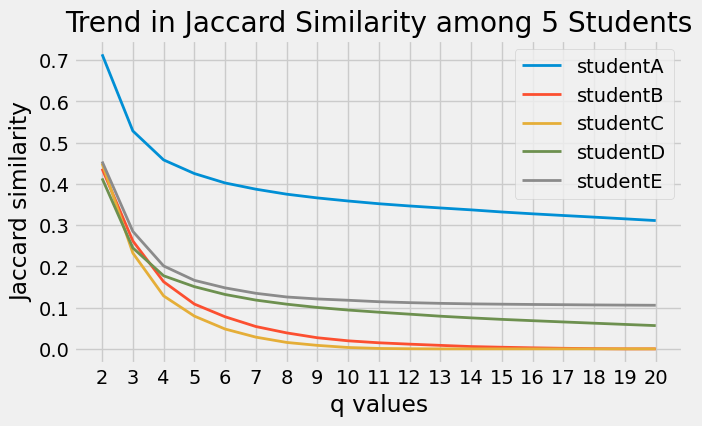

In [64]:
# the code to draw the plot
plt.figure(figsize=(7,4),dpi=100)
for s in sim_df.columns:
    plt.plot(sim_df[s],label=s,lw=2)
plt.xticks(np.arange(2,21))
plt.xlabel('q values')
plt.ylabel('Jaccard similarity')
plt.title('Trend in Jaccard Similarity among 5 Students')
plt.legend()

#### Question 4

What do the similarity values you calculated say about the five students (A,B,C, D and E)? Is there evidence for plagiarism for any of them? Write a short discussion of your findings.


There is only evidence for student A plagiarizing with a similarity score of 0.7 that falls to around 0.3 as q increases. This student's similarity score is significantly higher than that of the other students and is higher than the 0.5 we could use as a potential threshold. Student D and E have similarly low similarity scores, while Student B and C's scores are also similarly low and lower than those of students D and E. 

#### Question 5

Assume that the original text is fixed, but that different amounts of it are plagiarized.  How does the length of the plagiarized text impact the Jaccard similarities? For example, would a plagiarized short paper (1-2 sentences) typically have a different Jaccard similarity than a plagiarized long paper (few paragraphs)? Is this important for our five student scenario?

This is an open-ended question. You can answer it by changing the length of a plagiarized text and calculating similarities, you can argue it mathematically, or you can do some combination of these. 



In [66]:
for s in students:
    print(len(s))


1243
1368
1076
493
610


In [72]:
print("Length of Original:", len(original))
print("Length of Student E:", len(studentE))
print("Student E similarity by Jaccard:", jaccard_simq(original,studentE,2))

set1 = set(qgram(original,q)) 
set2 = set(qgram(studentE,q))

common_tokens = set1.intersection(set2)
print("Percentage of Student E tokens that overlap between original and Student E:",float(len(common_tokens) / len(set2)))

Length of Original: 3098
Length of Student E: 610
Student E similarity by Jaccard: 0.45414847161572053
Percentage of Student E tokens that overlap between original and Student E: 0.5902192242833052


In thinking about this problem mathematically, we see that the way Jaccard similarity is calculated is by dividing the number of shared tokens by the total number of tokens. However, when comparing texts of different lengths, specifically thinking about our context of seeing if a shorter summary is plagiarizing a larger text, the similarity score fails to capture the true similarity between the summary and the original text. This is because we're simply dividing the number of shared tokens by the total number of tokens, which means that even if all of the tokens in the shorter text are present in the longer text, the similarity score would still be low because the shorter text accounts for fewer of the total tokens between the two texts. As such, we may fail to detect plagiarism in these shorter texts since Jaccard is measuring total similarity between the texts. 

We can see this to an extent with Student E, where despite many of the tokens of Student E being in the original text, since the original is significantly larger than Student E's text, the Jaccard similarity score is lower than the true proportion.